In [10]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
from scipy.interpolate import griddata
from scipy.spatial import SphericalVoronoi, cKDTree
import xarray as xr
import pandas as pd

import matplotlib.pyplot as plt
import cartopy as cart
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cmocean

from datetime import timedelta as delta
from datetime import datetime

import networkx as nx

from parcels import (grid, Field, FieldSet, ParticleSet, JITParticle, ScipyParticle, AdvectionRK4,
                     ErrorCode, ParticleFile, Variable, plotTrajectoriesFile)
import sys
import pickle
from importlib import reload

sys.path.append('/home/students/4302001/arctic-connectivity/tools')
sys.path.append('/Users/daanreijnders/surfdrive/Thesis/repository/tools')
import plot
import lifeline
import community
import fieldsetter
import advectParticles

In [2]:
reload(plot)
reload(lifeline)
reload(community)
reload(fieldsetter)
reload(advectParticles)

Stripy is not available on this machine.


<module 'advectParticles' from '/home/students/4302001/arctic-connectivity/tools/advectParticles.py'>

In [50]:
readdir_ocean = '/data/oceanparcels/input_data/CESM/0.1_deg/rcp8.5/ocean/arctic/'
readdir_ice = '/data/oceanparcels/input_data/CESM/0.1_deg/control/ice/arctic/'
readdir_mesh = '/scratch/DaanR/fields/'

fieldfile_ocean_2000 = 'daily_CESM_0.1degree_rcp8.5run_years_2000-2010_arctic.nc'
fieldfile_ocean_2051 = "daily_CESM_0.1degree_rcp8.5run_years_2051-2060_arctic.nc"
fieldfile_ice = 'monthly_icefields_CESM_0.1degree_controlrun_year_300_arctic.nc'
meshfile = 'POP_grid_coordinates.nc'

writedir = '/scratch/DaanR/psets/'

psetdir = "/data/oceanparcels/output_data/data_Daan/psets/"

In [4]:
ds = xr.open_dataset(readdir_ocean+fieldfile_ocean_2051)

In [7]:
timestamps_2000 = [[np.datetime64('2000-01-09', 'D') + np.timedelta64(day, 'D') for day in range(4007)]]
timestamps_2051 = [[np.datetime64('2051-01-01', 'D') + np.timedelta64(day, 'D') for day in range(3650)]]
fieldset_2000 = fieldsetter.read_velocity_field(readdir_ocean + fieldfile_ocean_2000, 
                                                meshfile = readdir_mesh+meshfile,
                                                tindex = 'record',
                                                timestamps = timestamps_2000)
fieldset_2051 = fieldsetter.read_velocity_field(readdir_ocean + fieldfile_ocean_2051, 
                                                meshfile = readdir_mesh+meshfile,
                                                tindex = 'record',
                                                timestamps = timestamps_2051)

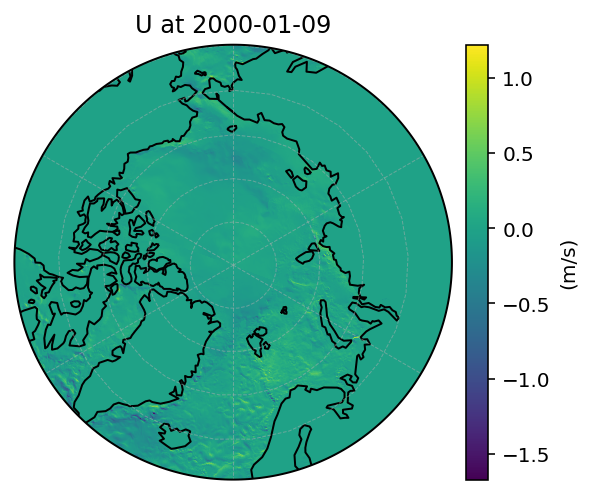

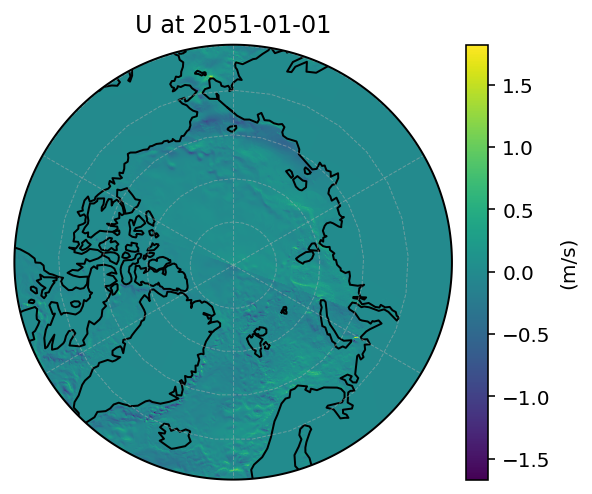

In [8]:
fig, ax = plot.from_field(fieldset_2000.U, polar=True, land=False, latRange=(60,90))
plt.show()
fig, ax = plot.from_field(fieldset_2051.U, polar=True, land=False, latRange=(60,90))
plt.show()

In [32]:
with open('/scratch/DaanR/meshes/ico_mesh_hex_r6.pickle', 'rb') as meshPick6:
    meshDict6 = pickle.load(meshPick6)
with open('/scratch/DaanR/meshes/ico_mesh_hex_r7.pickle', 'rb') as meshPick7:
    meshDict7 = pickle.load(meshPick7)
with open('/scratch/DaanR/meshes/ico_mesh_hex_r8.pickle', 'rb') as meshPick8:
    meshDict8 = pickle.load(meshPick8)

In [33]:
myBins6_1 = community.hexCountBins(meshDict6['points'], 
                                 np.degrees(meshDict6['lons']), 
                                 np.degrees(meshDict6['lats']), 
                                 meshDict6['permutation'], 
                                 meshDict6['simplices'])
myBins6_1.calculate_neighbors()

In [34]:
myBins7_1 = community.hexCountBins(meshDict7['points'], 
                                 np.degrees(meshDict7['lons']), 
                                 np.degrees(meshDict7['lats']), 
                                 meshDict7['permutation'], 
                                 meshDict7['simplices'])
myBins7_1.calculate_neighbors()

In [35]:
myBins8_1 = community.hexCountBins(meshDict8['points'], 
                                 np.degrees(meshDict8['lons']), 
                                 np.degrees(meshDict8['lats']), 
                                 meshDict8['permutation'], 
                                 meshDict8['simplices'])
myBins8_1.calculate_neighbors()

In [36]:
myMask6 = community.hexMask(myBins6_1, -45, 65, 60, 85)
myMask6.growToLevel(4)

In [37]:
myMask7 = community.hexMask(myBins7_1, -45, 65, 60, 85)
myMask7.growToLevel(4)

In [38]:
myMask8 = community.hexMask(myBins8_1, -45, 65, 60, 85)
myMask8.growToLevel(4)

In [39]:
myBins6_1.calculate_voronoi(myMask6, innerMaskLevel=2, outerMaskLevel=3)
myBins7_1.calculate_voronoi(myMask7, innerMaskLevel=2, outerMaskLevel=3)
myBins8_1.calculate_voronoi(myMask8, innerMaskLevel=2, outerMaskLevel=3)
del meshDict6
del meshDict7
del meshDict8

In [20]:
fullParts = community.particles.from_pickle('/scratch/DaanR/meshes/ico_mesh_parts_r11.pickle')
domainMask = np.logical_and(np.logical_and(np.degrees(fullParts.lats) > 60, 
                                           np.degrees(fullParts.lats) < 85),
                            np.logical_and(np.degrees(fullParts.lons) < 65,
                                           np.degrees(fullParts.lons) > -45))
pLons = np.degrees(fullParts.lons)[domainMask]
pLats = np.degrees(fullParts.lats)[domainMask]
particles = community.particles(pLons, pLats)
del fullParts
particles.remove_on_land(fieldset_2000)

In [44]:
particles.n

508362

In [40]:
myBins6_1.particle_count(particles);
myBins7_1.particle_count(particles);
myBins8_1.particle_count(particles);

array([63, 63, 63, ..., 64, 64, 64])

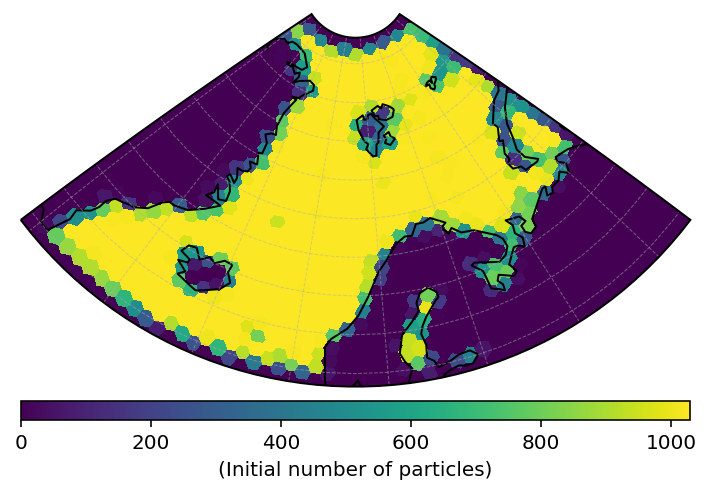

In [41]:
fig, ax = plot.triangular_field_from_dataset(myBins6_1.svTriLons, 
                                             myBins6_1.svTriLats, 
                                             myBins6_1.svSimplices[myBins6_1.svMask], 
                                             myBins6_1.initCount,
                                            lonRange = (-47, 67),
                                            latRange = (59, 86),
                                            wedge = True,
                                            export = "initcount_Cico6_Pico11.png",
                                            units = "Initial number of particles")

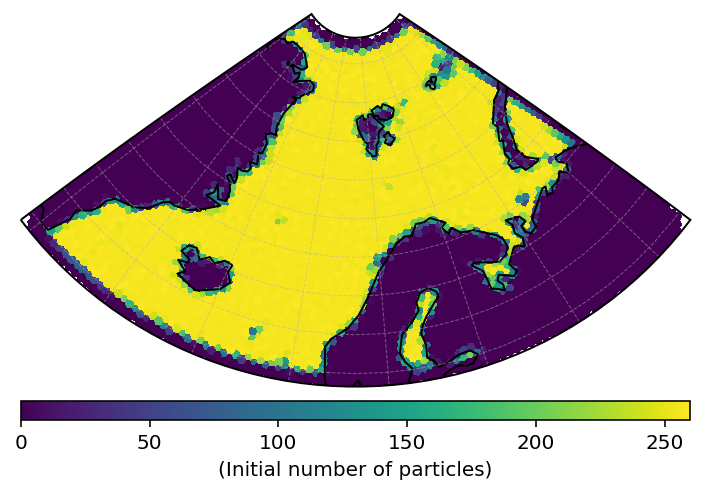

In [42]:
fig, ax = plot.triangular_field_from_dataset(myBins7_1.svTriLons, 
                                            myBins7_1.svTriLats, 
                                            myBins7_1.svSimplices[myBins7_1.svMask], 
                                            myBins7_1.initCount,
                                            lonRange = (-47, 67),
                                            latRange = (59, 86),
                                            wedge = True,
                                            export = "initcount_Cico7_Pico11.png",
                                            units = "Initial number of particles")

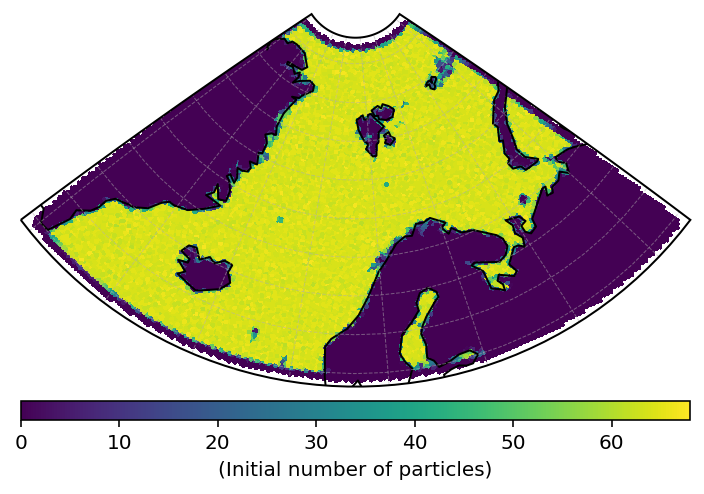

In [43]:
fig, ax = plot.triangular_field_from_dataset(myBins8_1.svTriLons, 
                                            myBins8_1.svTriLats, 
                                            myBins8_1.svSimplices[myBins8_1.svMask], 
                                            myBins8_1.initCount,
                                            lonRange = (-47, 67),
                                            latRange = (59, 86),
                                            wedge = True,
                                            export = "initcount_Cico8_Pico11.png",
                                            units = "Initial number of particles")

In [46]:
print("Sum of initCount on particleGrid:", myBins7_1.initCount.sum())
print("Removed particle count:", particles.removedParticleCount)
print("Particle count:", particles.n)

Sum of initCount on particleGrid: 3050172
Removed particle count: 346281
Particle count: 508362


In [64]:
transMat_Cico6_y2001_30d = community.transMat.from_pset(psetdir + "pset_Rrcp85_Pico11_S2001-12-1_D90_DT20_ODT24_wedge.nc", 
                                                        myBins6_1, 
                                                        np.timedelta64(30, 'D'))

 Determining particle bins. 100%

In [71]:
# Create network from numpy array (adjacency matrix)
G_Cico6_y2001_30d = nx.from_numpy_matrix(transMat_Cico6_y2001_30d.data, create_using=nx.DiGraph())
# Export to Pajek (.net) format for further manual processing
nx.write_pajek(G_Cico6_y2001_30d, '/data/oceanparcels/output_data/data_Daan/networks/network_pset_Rrcp85_Pico11_S2001-12-1_D90_DT20_ODT24_wedge_Cico6_subD30.net')

In [65]:
transMat_Cico7_y2001_30d = community.transMat.from_pset(psetdir + "pset_Rrcp85_Pico11_S2001-12-1_D90_DT20_ODT24_wedge.nc", 
                                                        myBins7_1, 
                                                        np.timedelta64(30, 'D'))

 Determining particle bins. 100%

In [72]:
# Create network from numpy array (adjacency matrix)
G_Cico7_y2001_30d = nx.from_numpy_matrix(transMat_Cico7_y2001_30d.data, create_using=nx.DiGraph())
# Export to Pajek (.net) format for further manual processing
nx.write_pajek(G_Cico7_y2001_30d, '/data/oceanparcels/output_data/data_Daan/networks/network_pset_Rrcp85_Pico11_S2001-12-1_D90_DT20_ODT24_wedge_Cico7_subD30.net')

In [68]:
transMat_Cico7_y2001_60d = community.transMat.from_pset(psetdir + "pset_Rrcp85_Pico11_S2001-12-1_D90_DT20_ODT24_wedge.nc", 
                                                        myBins7_1, 
                                                        np.timedelta64(60, 'D'))

 Determining particle bins. 100%

In [73]:
# Create network from numpy array (adjacency matrix)
G_Cico7_y2001_60d = nx.from_numpy_matrix(transMat_Cico7_y2001_60d.data, create_using=nx.DiGraph())
# Export to Pajek (.net) format for further manual processing
nx.write_pajek(G_Cico7_y2001_60d, '/data/oceanparcels/output_data/data_Daan/networks/network_pset_Rrcp85_Pico11_S2001-12-1_D90_DT20_ODT24_wedge_Cico7_subD60.net')

In [69]:
transMat_Cico7_y2001_90d = community.transMat.from_pset(psetdir + "pset_Rrcp85_Pico11_S2001-12-1_D90_DT20_ODT24_wedge.nc", 
                                                        myBins7_1, 
                                                        np.timedelta64(90, 'D'))

 Determining particle bins. 100%

In [74]:
# Create network from numpy array (adjacency matrix)
G_Cico7_y2001_90d = nx.from_numpy_matrix(transMat_Cico7_y2001_90d.data, create_using=nx.DiGraph())
# Export to Pajek (.net) format for further manual processing
nx.write_pajek(G_Cico7_y2001_90d, '/data/oceanparcels/output_data/data_Daan/networks/network_pset_Rrcp85_Pico11_S2001-12-1_D90_DT20_ODT24_wedge_Cico7.net')

In [66]:
transMat_Cico7_y2051_30d = community.transMat.from_pset(psetdir + "pset_Rrcp85_Pico11_S2051-12-1_D90_DT20_ODT24_wedge.nc", 
                                                        myBins7_1, 
                                                        np.timedelta64(30, 'D'))

 Determining particle bins. 100%

In [75]:
# Create network from numpy array (adjacency matrix)
G_Cico7_y2051_30d = nx.from_numpy_matrix(transMat_Cico7_y2051_30d.data, create_using=nx.DiGraph())
# Export to Pajek (.net) format for further manual processing
nx.write_pajek(G_Cico7_y2051_30d, '/data/oceanparcels/output_data/data_Daan/networks/network_pset_Rrcp85_Pico11_S2051-12-1_D90_DT20_ODT24_wedge_Cico7_subD30.net')

In [67]:
transMat_Cico8_y2001_30d = community.transMat.from_pset(psetdir + "pset_Rrcp85_Pico11_S2001-12-1_D90_DT20_ODT24_wedge.nc", 
                                                        myBins8_1, 
                                                        np.timedelta64(30, 'D'))

 Determining particle bins. 100%

In [76]:
# Create network from numpy array (adjacency matrix)
G_Cico8_y2001_30d = nx.from_numpy_matrix(transMat_Cico8_y2001_30d.data, create_using=nx.DiGraph())
# Export to Pajek (.net) format for further manual processing
nx.write_pajek(G_Cico8_y2001_30d, '/data/oceanparcels/output_data/data_Daan/networks/network_pset_Rrcp85_Pico11_S2001-12-1_D90_DT20_ODT24_wedge_Cico8_subD30.net')

In [90]:
transMat_Cico7_march = community.transMat.from_pset(psetdir + "pset_Rrcp85_Pico11_S2001-3-1_D90_DT20_ODT24_wedge.nc", 
                                                        myBins7_1, 
                                                        np.timedelta64(30, 'D'))
# Create network from numpy array (adjacency matrix)
G_Cico7_march = nx.from_numpy_matrix(transMat_Cico7_march.data, create_using=nx.DiGraph())
# Export to Pajek (.net) format for further manual processing
nx.write_pajek(G_Cico7_march, '/data/oceanparcels/output_data/data_Daan/networks/network_pset_Rrcp85_Pico11_S2001-3-1_D90_DT20_ODT24_wedge.net')

 Determining particle bins. 100%

In [91]:
transMat_Cico7_sept = community.transMat.from_pset(psetdir + "pset_Rrcp85_Pico11_S2001-9-1_D90_DT20_ODT24_wedge.nc", 
                                                        myBins7_1, 
                                                        np.timedelta64(30, 'D'))
# Create network from numpy array (adjacency matrix)
G_Cico7_sept = nx.from_numpy_matrix(transMat_Cico7_sept.data, create_using=nx.DiGraph())
# Export to Pajek (.net) format for further manual processing
nx.write_pajek(G_Cico7_sept, '/data/oceanparcels/output_data/data_Daan/networks/network_pset_Rrcp85_Pico11_S2001-9-1_D90_DT20_ODT24_wedge.net')

 Determining particle bins. 100%

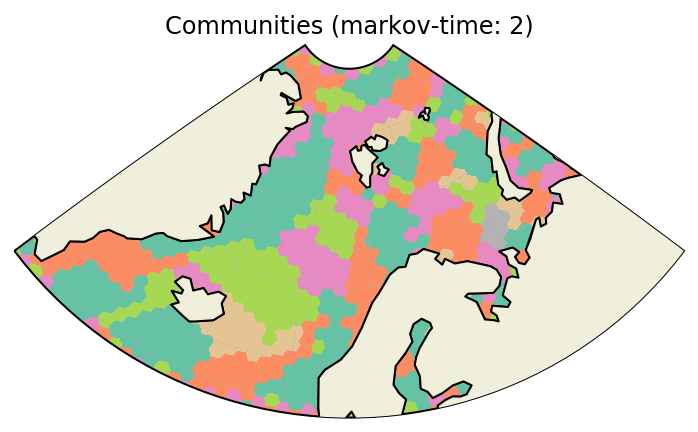

In [80]:
myBins6_1.load_communities('/data/oceanparcels/output_data/data_Daan/communities/network_pset_Rrcp85_Pico11_S2001-12-1_D90_DT20_ODT24_wedge_Cico6_subD30_m2.clu')
myBins6_1.find_adjacency();
myBins6_1.color_communities();
fig, ax = plot.triangular_field_from_dataset(myBins6_1.svTriLons, 
                                             myBins6_1.svTriLats, 
                                             myBins6_1.svSimplices[myBins6_1.svMask], 
                                             np.array(myBins6_1.colorID)[myBins6_1.svSimplices[:,0][myBins6_1.svMask]], 
                                            lonRange = (-47, 67),
                                            latRange = (59, 86),
                                            land = True,
                                            colormap = "Set2",
                                            wedge = True,
                                            export = "network_pset_Rrcp85_Pico11_S2001-12-1_D90_DT20_ODT24_wedge_Cico6_subD30_m2.png",
                                            cbar=False,
                                            title = "Communities (markov-time: 2)"
                                            )
plt.show()

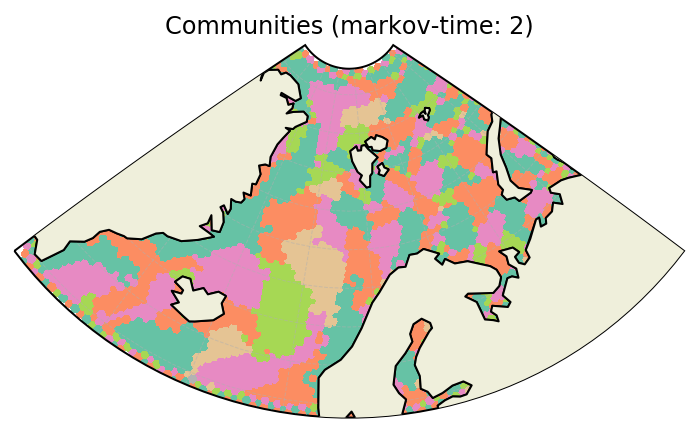

In [81]:
myBins7_1.load_communities('/data/oceanparcels/output_data/data_Daan/communities/network_pset_Rrcp85_Pico11_S2001-12-1_D90_DT20_ODT24_wedge_Cico7_subD30_m2.clu')
myBins7_1.find_adjacency();
myBins7_1.color_communities();
fig, ax = plot.triangular_field_from_dataset(myBins7_1.svTriLons, 
                                             myBins7_1.svTriLats, 
                                             myBins7_1.svSimplices[myBins7_1.svMask], 
                                             np.array(myBins7_1.colorID)[myBins7_1.svSimplices[:,0][myBins7_1.svMask]], 
                                            lonRange = (-47, 67),
                                            latRange = (59, 86),
                                            land = True,
                                            colormap = "Set2",
                                            wedge = True,
                                            export = "communities_pset_Rrcp85_Pico11_S2001-12-1_D90_DT20_ODT24_wedge_Cico7_subD30_m2.png",
                                            cbar=False,
                                            title = "Communities (markov-time: 2)"
                                            )
plt.show()

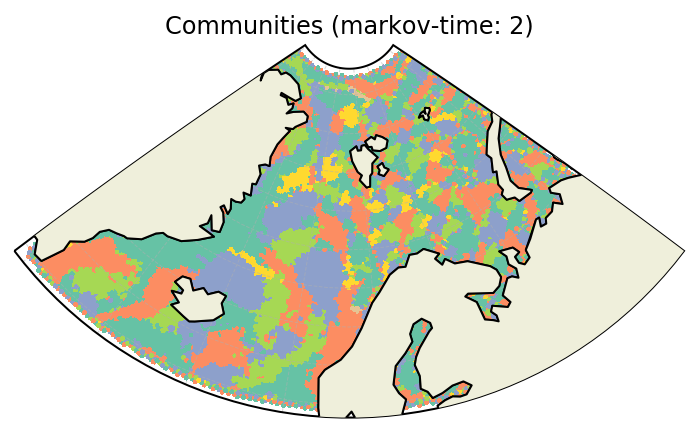

In [82]:
myBins8_1.load_communities('/data/oceanparcels/output_data/data_Daan/communities/network_pset_Rrcp85_Pico11_S2001-12-1_D90_DT20_ODT24_wedge_Cico8_subD30_m2.clu')
myBins8_1.find_adjacency();
myBins8_1.color_communities();
fig, ax = plot.triangular_field_from_dataset(myBins8_1.svTriLons, 
                                             myBins8_1.svTriLats, 
                                             myBins8_1.svSimplices[myBins8_1.svMask], 
                                             np.array(myBins8_1.colorID)[myBins8_1.svSimplices[:,0][myBins8_1.svMask]], 
                                            lonRange = (-47, 67),
                                            latRange = (59, 86),
                                            land = True,
                                            colormap = "Set2",
                                            wedge = True,
                                            export = "communities_pset_Rrcp85_Pico11_S2001-12-1_D90_DT20_ODT24_wedge_Cico8_subD30_m2.png",
                                            cbar=False,
                                            title = "Communities (markov-time: 2)"
                                            )
plt.show()

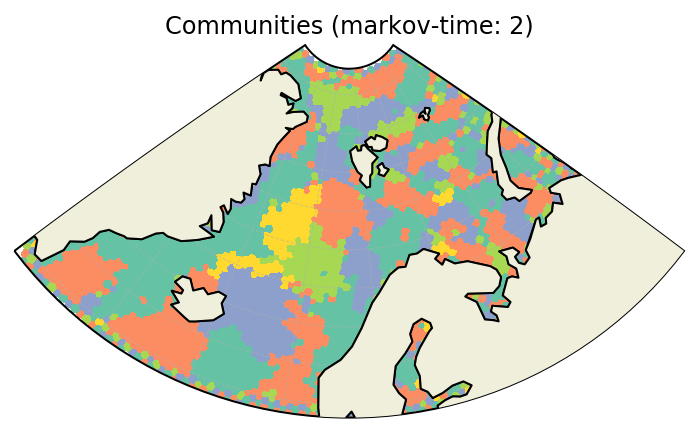

In [83]:
# 60 days
myBins7_1.load_communities('/data/oceanparcels/output_data/data_Daan/communities/network_pset_Rrcp85_Pico11_S2001-12-1_D90_DT20_ODT24_wedge_Cico7_subD60_m2.clu')
myBins7_1.find_adjacency();
myBins7_1.color_communities();
fig, ax = plot.triangular_field_from_dataset(myBins7_1.svTriLons, 
                                             myBins7_1.svTriLats, 
                                             myBins7_1.svSimplices[myBins7_1.svMask], 
                                             np.array(myBins7_1.colorID)[myBins7_1.svSimplices[:,0][myBins7_1.svMask]], 
                                            lonRange = (-47, 67),
                                            latRange = (59, 86),
                                            land = True,
                                            colormap = "Set2",
                                            wedge = True,
                                            export = "communities_pset_Rrcp85_Pico11_S2001-12-1_D90_DT20_ODT24_wedge_Cico7_subD60_m2.png",
                                            cbar=False,
                                            title = "Communities (markov-time: 2)"
                                            )
plt.show()

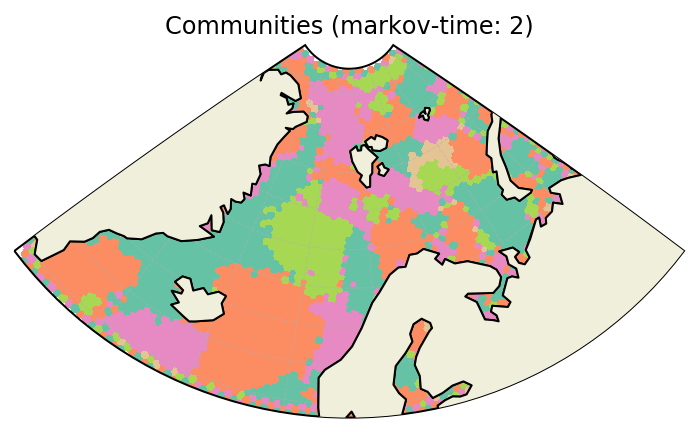

In [84]:
# 90 days
myBins7_1.load_communities('/data/oceanparcels/output_data/data_Daan/communities/network_pset_Rrcp85_Pico11_S2001-12-1_D90_DT20_ODT24_wedge_Cico7_m2.clu')
myBins7_1.find_adjacency();
myBins7_1.color_communities();
fig, ax = plot.triangular_field_from_dataset(myBins7_1.svTriLons, 
                                             myBins7_1.svTriLats, 
                                             myBins7_1.svSimplices[myBins7_1.svMask], 
                                             np.array(myBins7_1.colorID)[myBins7_1.svSimplices[:,0][myBins7_1.svMask]], 
                                            lonRange = (-47, 67),
                                            latRange = (59, 86),
                                            land = True,
                                            colormap = "Set2",
                                            wedge = True,
                                            export = "communities_pset_Rrcp85_Pico11_S2001-12-1_D90_DT20_ODT24_wedge_Cico7_m2.png",
                                            cbar=False,
                                            title = "Communities (markov-time: 2)"
                                            )
plt.show()

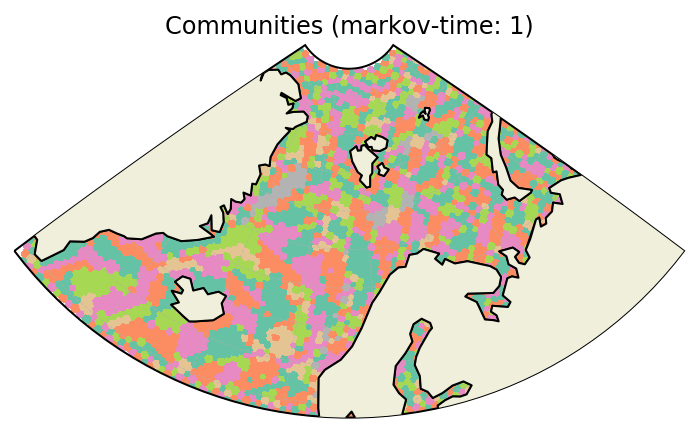

In [86]:
myBins7_1.load_communities('/data/oceanparcels/output_data/data_Daan/communities/network_pset_Rrcp85_Pico11_S2001-12-1_D90_DT20_ODT24_wedge_Cico7_subD30_m1.clu')
myBins7_1.find_adjacency();
myBins7_1.color_communities();
fig, ax = plot.triangular_field_from_dataset(myBins7_1.svTriLons, 
                                             myBins7_1.svTriLats, 
                                             myBins7_1.svSimplices[myBins7_1.svMask], 
                                             np.array(myBins7_1.colorID)[myBins7_1.svSimplices[:,0][myBins7_1.svMask]], 
                                            lonRange = (-47, 67),
                                            latRange = (59, 86),
                                            land = True,
                                            colormap = "Set2",
                                            wedge = True,
                                            export = "communities_pset_Rrcp85_Pico11_S2001-12-1_D90_DT20_ODT24_wedge_Cico7_subD30_m1.png",
                                            cbar=False,
                                            title = "Communities (markov-time: 1)"
                                            )
plt.show()

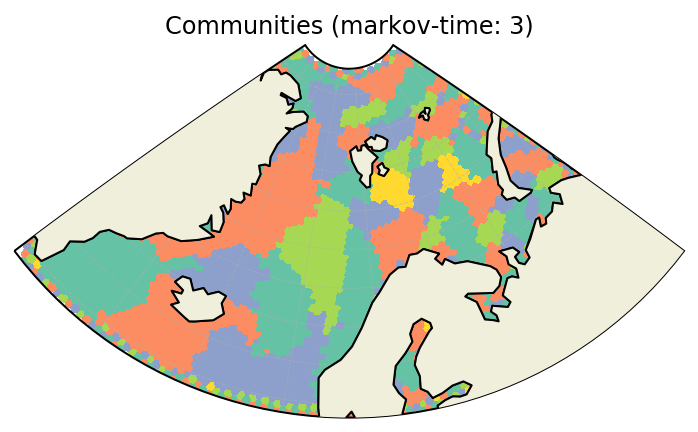

In [87]:
myBins7_1.load_communities('/data/oceanparcels/output_data/data_Daan/communities/network_pset_Rrcp85_Pico11_S2001-12-1_D90_DT20_ODT24_wedge_Cico7_subD30_m3.clu')
myBins7_1.find_adjacency();
myBins7_1.color_communities();
fig, ax = plot.triangular_field_from_dataset(myBins7_1.svTriLons, 
                                             myBins7_1.svTriLats, 
                                             myBins7_1.svSimplices[myBins7_1.svMask], 
                                             np.array(myBins7_1.colorID)[myBins7_1.svSimplices[:,0][myBins7_1.svMask]], 
                                            lonRange = (-47, 67),
                                            latRange = (59, 86),
                                            land = True,
                                            colormap = "Set2",
                                            wedge = True,
                                            export = "communities_pset_Rrcp85_Pico11_S2001-12-1_D90_DT20_ODT24_wedge_Cico7_subD30_m3.png",
                                            cbar=False,
                                            title = "Communities (markov-time: 3)"
                                            )
plt.show()

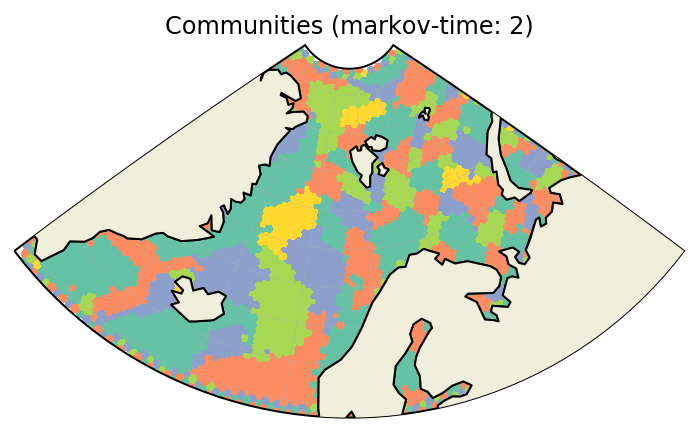

In [88]:
#undirected
myBins7_1.load_communities('/data/oceanparcels/output_data/data_Daan/communities/network_pset_Rrcp85_Pico11_S2001-12-1_D90_DT20_ODT24_wedge_Cico7_subD30_m2_undirected.clu')
myBins7_1.find_adjacency();
myBins7_1.color_communities();
fig, ax = plot.triangular_field_from_dataset(myBins7_1.svTriLons, 
                                             myBins7_1.svTriLats, 
                                             myBins7_1.svSimplices[myBins7_1.svMask], 
                                             np.array(myBins7_1.colorID)[myBins7_1.svSimplices[:,0][myBins7_1.svMask]], 
                                            lonRange = (-47, 67),
                                            latRange = (59, 86),
                                            land = True,
                                            colormap = "Set2",
                                            wedge = True,
                                            export = "communities_pset_Rrcp85_Pico11_S2001-12-1_D90_DT20_ODT24_wedge_Cico7_subD30_m2_undirected.png",
                                            cbar=False,
                                            title = "Communities (markov-time: 2)"
                                            )
plt.show()

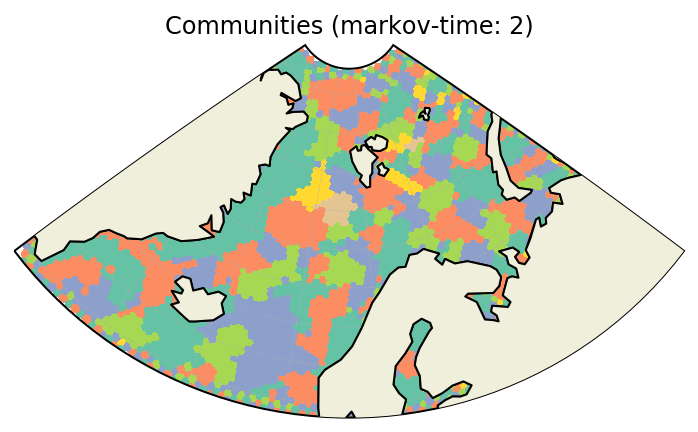

In [94]:
#2051
myBins7_1.load_communities('/data/oceanparcels/output_data/data_Daan/communities/network_pset_Rrcp85_Pico11_S2051-12-1_D90_DT20_ODT24_wedge_Cico7_subD30_m2.clu')
myBins7_1.find_adjacency();
myBins7_1.color_communities();
fig, ax = plot.triangular_field_from_dataset(myBins7_1.svTriLons, 
                                             myBins7_1.svTriLats, 
                                             myBins7_1.svSimplices[myBins7_1.svMask], 
                                             np.array(myBins7_1.colorID)[myBins7_1.svSimplices[:,0][myBins7_1.svMask]], 
                                            lonRange = (-47, 67),
                                            latRange = (59, 86),
                                            land = True,
                                            colormap = "Set2",
                                            wedge = True,
                                            export = "communities_pset_Rrcp85_Pico11_S2051-12-1_D90_DT20_ODT24_wedge_Cico7_subD30_m2.png",
                                            cbar=False,
                                            title = "Communities (markov-time: 2)"
                                            )
plt.show()

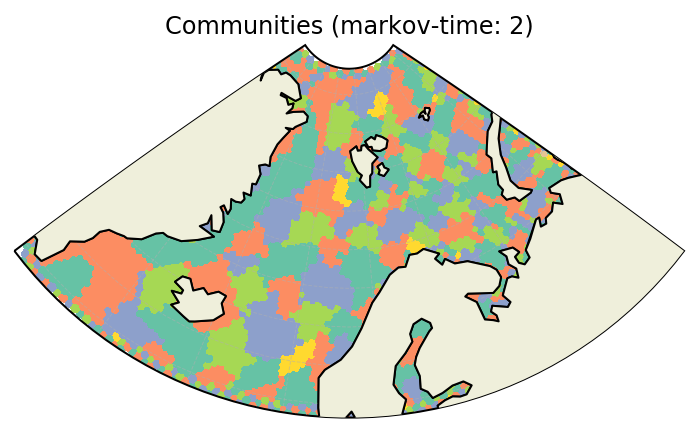

In [96]:
#march
myBins7_1.load_communities('/data/oceanparcels/output_data/data_Daan/communities/network_pset_Rrcp85_Pico11_S2001-3-1_D90_DT20_ODT24_wedge_Cico7_subD30_m2.clu')
myBins7_1.find_adjacency();
myBins7_1.color_communities();
fig, ax = plot.triangular_field_from_dataset(myBins7_1.svTriLons, 
                                             myBins7_1.svTriLats, 
                                             myBins7_1.svSimplices[myBins7_1.svMask], 
                                             np.array(myBins7_1.colorID)[myBins7_1.svSimplices[:,0][myBins7_1.svMask]], 
                                            lonRange = (-47, 67),
                                            latRange = (59, 86),
                                            land = True,
                                            colormap = "Set2",
                                            wedge = True,
                                            export = "communities_pset_Rrcp85_Pico11_S2001-3-1_D90_DT20_ODT24_wedge_Cico7_subD30_m2.png",
                                            cbar=False,
                                            title = "Communities (markov-time: 2)"
                                            )
plt.show()

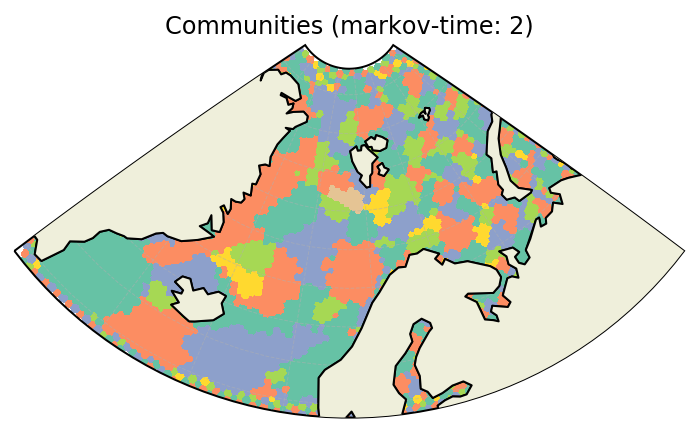

In [98]:
#september
myBins7_1.load_communities('/data/oceanparcels/output_data/data_Daan/communities/network_pset_Rrcp85_Pico11_S2001-9-1_D90_DT20_ODT24_wedge_Cico7_subD30_m2.clu')
myBins7_1.find_adjacency();
myBins7_1.color_communities();
fig, ax = plot.triangular_field_from_dataset(myBins7_1.svTriLons, 
                                             myBins7_1.svTriLats, 
                                             myBins7_1.svSimplices[myBins7_1.svMask], 
                                             np.array(myBins7_1.colorID)[myBins7_1.svSimplices[:,0][myBins7_1.svMask]], 
                                            lonRange = (-47, 67),
                                            latRange = (59, 86),
                                            land = True,
                                            colormap = "Set2",
                                            wedge = True,
                                            export = "communities_pset_Rrcp85_Pico11_S2001-9-1_D90_DT20_ODT24_wedge_Cico7_subD30_m2.png",
                                            cbar=False,
                                            title = "Communities (markov-time: 2)"
                                            )
plt.show()